<a href="https://colab.research.google.com/github/PhataPoster/CNN/blob/main/210110.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Install required packages
!pip install torch torchvision tensorflow tensorflow-datasets pandas matplotlib seaborn scikit-learn

# Clone your GitHub repository to access custom images
!git clone https://github.com/PhataPoster/CNN
import os
custom_data_dir = '/content/CNN/dataset'

# Import PyTorch and other core libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
import torchvision.transforms as transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Cloning into 'CNN'...
remote: Enumerating objects: 25, done.
remote: Counting objects: 100% (25/25), done.
remote: Compressing objects: 100% (22/22), done.
remote: Total 25 (delta 2), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (25/25), 106.90 KiB | 4.11 MiB/s, done.
Resolving deltas: 100% (2/2), done.


In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds

# Load the Rock Paper Scissors dataset from TensorFlow
print("Loading Rock Paper Scissors dataset...")
train_ds_tf, test_ds_tf = tfds.load('rock_paper_scissors',
                                     split=['train', 'test'],
                                     as_supervised=True,
                                     batch_size=-1)  # Get full dataset as tensors

# Convert TensorFlow datasets to NumPy arrays
X_train_np, y_train_np = tfds.as_numpy(train_ds_tf)
X_test_np, y_test_np = tfds.as_numpy(test_ds_tf)

# Define the exact transforms used for training
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((150, 150)),  # Resize to 150x150 for efficient training
    transforms.ToTensor(),          # Convert to PyTorch tensor
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize
])

# A function to apply transforms and create DataLoader
def create_dataloader(images_np, labels_np, batch_size=32, shuffle=False):
    """Converts numpy arrays to a PyTorch DataLoader."""
    images_tensor = torch.stack([transform(img) for img in images_np])
    labels_tensor = torch.from_numpy(labels_np).long()
    dataset = TensorDataset(images_tensor, labels_tensor)
    return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)

# Create DataLoaders
batch_size = 32
train_loader = create_dataloader(X_train_np, y_train_np, batch_size, shuffle=True)
test_loader = create_dataloader(X_test_np, y_test_np, batch_size, shuffle=False)
print(f"Training batches: {len(train_loader)}, Test batches: {len(test_loader)}")

Loading Rock Paper Scissors dataset...


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/rock_paper_scissors/incomplete.BYXDGS_3.0.0/rock_paper_scissors-train.tfre…

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/rock_paper_scissors/incomplete.BYXDGS_3.0.0/rock_paper_scissors-test.tfrec…

Dataset rock_paper_scissors downloaded and prepared to /root/tensorflow_datasets/rock_paper_scissors/3.0.0. Subsequent calls will reuse this data.
Training batches: 79, Test batches: 12


In [ ]:
class RPS_CNN(nn.Module):
    """CNN for classifying Rock, Paper, Scissors images."""
    def __init__(self, num_classes=3):
        super(RPS_CNN, self).__init__()
        # Feature extraction layers
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),  # Conv Layer 1
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),       # Pooling Layer 1
            nn.Conv2d(32, 64, kernel_size=3, padding=1), # Conv Layer 2
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),       # Pooling Layer 2
            nn.Conv2d(64, 128, kernel_size=3, padding=1),# Conv Layer 3
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),       # Pooling Layer 3
        )
        # Classifier layers
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),  # Dropout for regularization
            nn.Linear(128 * 18 * 18, 512),  # Adjust based on final feature map size
            nn.ReLU(inplace=True),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)  # Flatten the tensor
        x = self.classifier(x)
        return x

# Initialize the model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = RPS_CNN(num_classes=3).to(device)
print(model)

RPS_CNN(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=41472, out_features=512, bias=True)
    (2): ReLU(inplace=True)
    (3): Linear(in_features=512, out_features=3, bias=True)
  )
)


In [ ]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Using Adam optimizer

# Training function
def train_model(model, train_loader, test_loader, epochs=10):
    train_losses, val_losses = [], []
    train_accs, val_accs = [], []

    for epoch in range(epochs):
        model.train()
        running_loss, correct, total = 0.0, 0, 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()           # Reset gradients
            outputs = model(images)         # Forward pass
            loss = criterion(outputs, labels)
            loss.backward()                 # Backward pass
            optimizer.step()                # Update weights

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        # Calculate training accuracy
        train_acc = 100 * correct / total
        train_losses.append(running_loss/len(train_loader))
        train_accs.append(train_acc)

        # Validation phase
        model.eval()
        val_loss, val_correct, val_total = 0.0, 0, 0
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        val_acc = 100 * val_correct / val_total
        val_losses.append(val_loss/len(test_loader))
        val_accs.append(val_acc)

        print(f"Epoch {epoch+1}/{epochs}: "
              f"Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_acc:.2f}%, "
              f"Val Loss: {val_losses[-1]:.4f}, Val Acc: {val_acc:.2f}%")

    return train_losses, val_losses, train_accs, val_accs

# Start training
epochs = 10
print("Starting training...")
history = train_model(model, train_loader, test_loader, epochs)

Starting training...
Epoch 1/10: Train Loss: 0.5464, Train Acc: 74.96%, Val Loss: 0.2957, Val Acc: 84.41%
Epoch 2/10: Train Loss: 0.0202, Train Acc: 99.40%, Val Loss: 0.3595, Val Acc: 90.05%
Epoch 3/10: Train Loss: 0.0039, Train Acc: 99.92%, Val Loss: 0.4987, Val Acc: 88.17%
Epoch 4/10: Train Loss: 0.0005, Train Acc: 100.00%, Val Loss: 0.4961, Val Acc: 88.44%
Epoch 5/10: Train Loss: 0.0002, Train Acc: 100.00%, Val Loss: 0.4549, Val Acc: 88.71%
Epoch 6/10: Train Loss: 0.0003, Train Acc: 100.00%, Val Loss: 0.5251, Val Acc: 86.83%
Epoch 7/10: Train Loss: 0.0001, Train Acc: 100.00%, Val Loss: 0.6672, Val Acc: 84.14%
Epoch 8/10: Train Loss: 0.0001, Train Acc: 100.00%, Val Loss: 0.6424, Val Acc: 88.44%
Epoch 9/10: Train Loss: 0.0125, Train Acc: 99.64%, Val Loss: 0.7259, Val Acc: 81.72%
Epoch 10/10: Train Loss: 0.0096, Train Acc: 99.80%, Val Loss: 0.5755, Val Acc: 81.45%


In [ ]:
# Save model weights
model_save_path = '/content/210110.pth'
torch.save(model.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")

# To load it later:
# model.load_state_dict(torch.load(model_save_path))

Model saved to /content/210110.pth


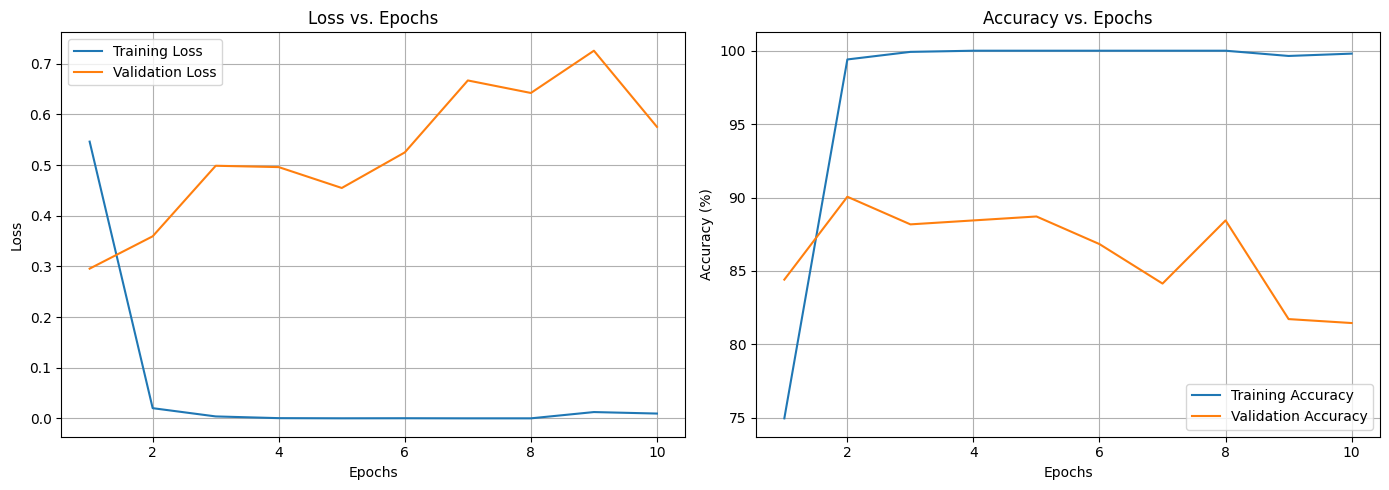

In [ ]:
def plot_training_history(history):
    """Plots loss and accuracy curves."""
    train_losses, val_losses, train_accs, val_accs = history
    epochs_range = range(1, len(train_losses) + 1)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

    # Plot Loss
    ax1.plot(epochs_range, train_losses, label='Training Loss')
    ax1.plot(epochs_range, val_losses, label='Validation Loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.set_title('Loss vs. Epochs')
    ax1.legend()
    ax1.grid(True)

    # Plot Accuracy
    ax2.plot(epochs_range, train_accs, label='Training Accuracy')
    ax2.plot(epochs_range, val_accs, label='Validation Accuracy')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy (%)')
    ax2.set_title('Accuracy vs. Epochs')
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

plot_training_history(history)

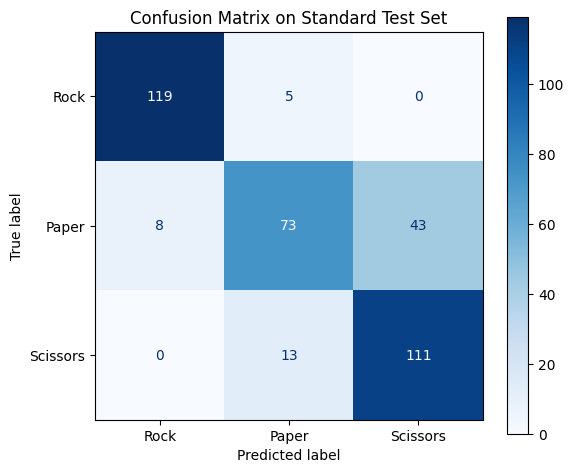

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def plot_confusion_matrix(model, test_loader):
    """Generates and displays a confusion matrix."""
    model.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.numpy())

    # Create confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                  display_labels=['Rock', 'Paper', 'Scissors'])
    fig, ax = plt.subplots(figsize=(6, 5))
    disp.plot(cmap='Blues', ax=ax, values_format='d')
    plt.title('Confusion Matrix on Standard Test Set')
    plt.tight_layout()
    plt.show()

plot_confusion_matrix(model, test_loader)

In [ ]:
# Define the same transform used for training data
def process_custom_image(image_path):
    """Loads and preprocesses a single custom image."""
    img = Image.open(image_path).convert('RGB')
    transform = transforms.Compose([
        transforms.Resize((150, 150)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])
    return transform(img).unsqueeze(0)  # Add batch dimension

# Get paths to your custom images from the cloned repo
custom_image_paths = [os.path.join(custom_data_dir, f) for f in os.listdir(custom_data_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
class_names = ['Rock', 'Paper', 'Scissors']

# Run predictions
model.eval()
predictions = []
with torch.no_grad():
    for img_path in custom_image_paths:
        tensor = process_custom_image(img_path).to(device)
        output = model(tensor)
        probabilities = torch.nn.functional.softmax(output[0], dim=0)
        confidence, predicted_idx = torch.max(probabilities, 0)
        predictions.append({
            'path': img_path,
            'predicted': class_names[predicted_idx.item()],
            'confidence': confidence.item() * 100
        })

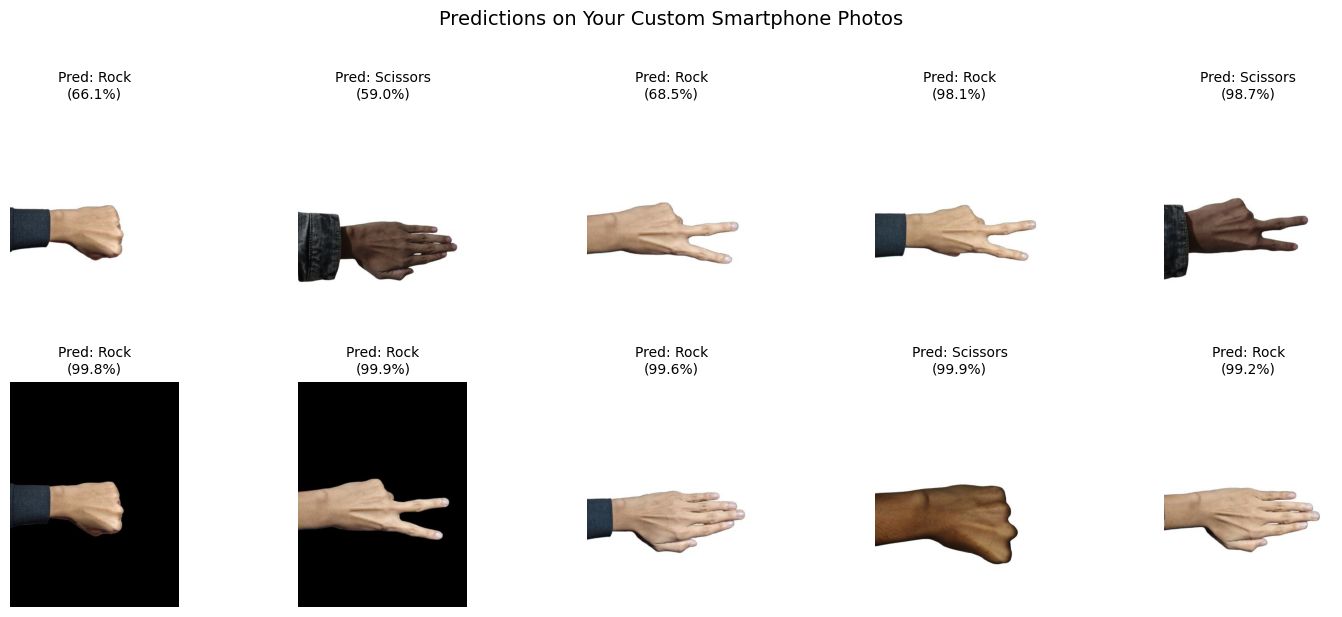

In [ ]:
def display_prediction_gallery(predictions, cols=5):
    """Displays a grid of custom images with predictions."""
    num_images = len(predictions)
    rows = (num_images + cols - 1) // cols
    fig, axes = plt.subplots(rows, cols, figsize=(cols*3, rows*3))
    axes = axes.flatten() if num_images > 1 else [axes]

    for idx, pred in enumerate(predictions):
        img = Image.open(pred['path'])
        axes[idx].imshow(img)
        title = f"Pred: {pred['predicted']}\n({pred['confidence']:.1f}%)"
        axes[idx].set_title(title, fontsize=10)
        axes[idx].axis('off')

    # Hide empty subplots
    for idx in range(num_images, len(axes)):
        axes[idx].axis('off')

    plt.suptitle('Predictions on Your Custom Smartphone Photos', fontsize=14, y=1.02)
    plt.tight_layout()
    plt.show()

display_prediction_gallery(predictions)

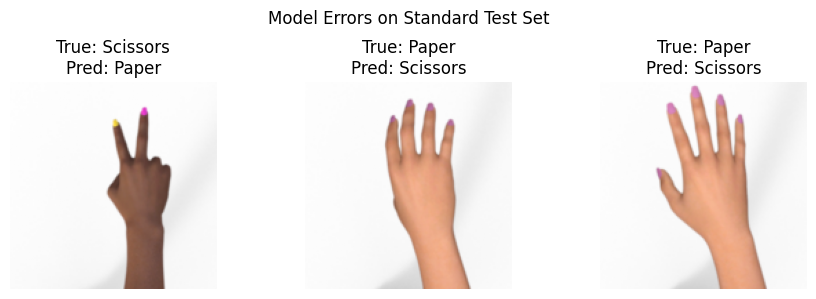

In [ ]:
def display_errors(model, test_loader, num_errors=3):
    """Displays misclassified images from the standard test set."""
    model.eval()
    error_images, error_true, error_pred = [], [], []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            # Find incorrect predictions
            incorrect_mask = (preds != labels)
            incorrect_images = images[incorrect_mask].cpu()
            incorrect_true = labels[incorrect_mask].cpu()
            incorrect_pred = preds[incorrect_mask].cpu()

            error_images.extend(incorrect_images)
            error_true.extend(incorrect_true)
            error_pred.extend(incorrect_pred)

            if len(error_images) >= num_errors:
                break

    # Display the errors
    fig, axes = plt.subplots(1, num_errors, figsize=(num_errors*3, 3))
    if num_errors == 1:
        axes = [axes]
    for i in range(min(num_errors, len(error_images))):
        img = error_images[i].permute(1, 2, 0).numpy()
        img = img * 0.5 + 0.5  # Unnormalize
        axes[i].imshow(np.clip(img, 0, 1))
        true_name = class_names[error_true[i]]
        pred_name = class_names[error_pred[i]]
        axes[i].set_title(f"True: {true_name}\nPred: {pred_name}")
        axes[i].axis('off')
    plt.suptitle('Model Errors on Standard Test Set', fontsize=12)
    plt.tight_layout()
    plt.show()

display_errors(model, test_loader, num_errors=3)